In [1]:
import numpy as np
import math
from mpmath import diff, coulombf, coulombg, mp
import matplotlib.pyplot as plt
import time
from numba import jit, njit
mp.dps = 8
coulf = np.frompyfunc(coulombf,3,1)
coulg = np.frompyfunc(coulombg,3,1)
c2 = 931.494
hc = 197.327

In [2]:
# reduced mass
def miu(mass1,mass2):
    return mass1*mass2/(mass1+mass2)
# Sommerfeld parameter    
def neta (Zch1, Zch2, mass, energy):
    return 0.1575*Zch1*Zch2*np.sqrt(mass/energy)
# k - wave vector
def kvector (mass, energy):
    return np.sqrt(2*mass*energy*c2/hc**2)
def fc(l, eta, rho):
    return diff( lambda z: coulf(l,eta,z), rho)
def gc(l, eta, rho):
    return diff( lambda z: coulg(l,eta,z), rho)
def penetration(l, E, Z1, Z2, m1, m2, R):
    eta = neta(Z1, Z2, miu(m1, m2), E)
    kvec = kvector( miu(m1, m2), E)
    rho = kvec * R
    return rho/(np.power(coulf(l,eta,rho),2)+np.power(coulg(l,eta,rho),2) )
def shift(l, E, Z1, Z2, m1, m2, R):
    eta = neta(Z1, Z2, miu(m1, m2), E)
    kvec = kvector( miu(m1,m2), E)
    rho = kvec * R
    summ =( coulf(l, eta, rho)*fc(l, eta, rho)+
    +coulg(l, eta, rho)*gc(l, eta, rho) )
    return summ*penetration(l, E, Z1, Z2, m1, m2, R)
def shiftder(l, E, Z1, Z2, m1, m2, R):
    return diff( lambda z: shift(l, z, Z1, Z2, m1, m2, R), E)

-0.27219386
-0.38744948
5.0165726 0.0648
5.0341241 0.0648
5.0142 0.0648
13.143528938293457 sec


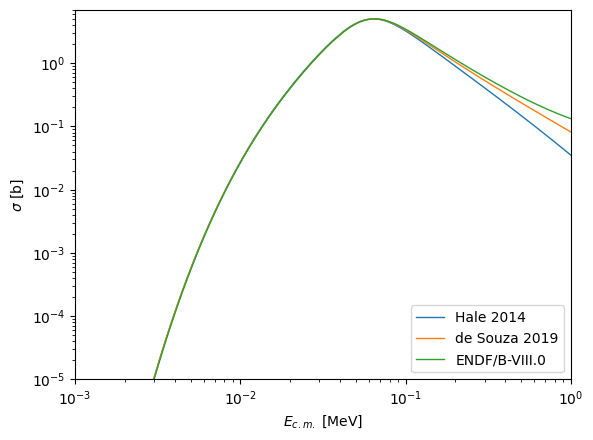

In [3]:
start = time.time()
Z1 = 1; Z3 = 0
Z2 = 1; Z4 = 2
m1 = 2; m3 = 1
m2 = 3; m4 = 4
l = 0 ; l2 = 2
J1 = 1 ; J2 = 0.5
J = 1.5
omega = (2*J+1) / (2*J1+1) / (2*J2+1) 
Qval = 17.59

# plot settings    
fig, ax = plt.subplots()
ax.set_xlabel('$E_{c.m.}$ [MeV]')
ax.set_ylabel('$\sigma$ [b]', rotation = 90)
ax.set(xlim = [0.001, 1], xscale = 'log')
ax.set(ylim = [1e-5, 7], yscale = 'log')
#ax.yaxis.set_label_coords(-0.2, 0.5)

# ENDF.VII-0 cross-section    
Elab, xs = np.genfromtxt('D_T_-_a_n.txt', comments='#', skip_footer=2, unpack=True)
Ecm = Elab*m2/(m1+m2)
E = Ecm

# 3/2+ resonance parameters 
# Hale 2014, de Souza 2019

Eb = 0.09654
gamd2 = np.array([0.324, 3.23]) 
gamn2 = np.array([0.0122, 0.133])
E1 = np.array([0.179, 0.0420])
R1 = np.array([7, 5.56])
R2 = np.array([7, 3.633])
bd = np.array([-0.59, shift(l, Eb, Z1, Z2, m1, m2, R1[1])])
bn = np.array([-2.0, shift(l2, Eb+Qval, Z3, Z4, m3, m4, R2[1])])

print(shift(l, Eb, Z1, Z2, m1, m2, R1[1]))
print(shift(l2, Eb+Qval, Z3, Z4, m3, m4, R2[1]))
# theory cross section - resonance 1.5+
for j in range(len(E1)):
    
    pl  = penetration(l, E, Z1, Z2, m1, m2, R1[j])
    pl2 = penetration(l2, E+Qval, Z3, Z4, m3, m4, R2[j])
    sh  = shift(l, E, Z1, Z2, m1, m2, R1[j])
    sh2 = shift(l2, E+Qval, Z3, Z4, m3, m4, R2[j])


    sigma = ( omega*np.pi*4*gamd2[j]*gamn2[j]*pl*pl2 / kvector(miu(m1,m2), E)**2 /100
           /((E1[j]-E - gamd2[j]*(sh-bd[j]) - gamn2[j]*(sh2-bn[j]))**2 
             +(gamd2[j]*pl+gamn2[j]*pl2)**2))
        
    ax.plot(Ecm, sigma, '-', linewidth = '1.0')
    print ( max(sigma), Ecm[np.argmax(sigma)])

ax.plot(Ecm, xs, '-', linewidth = '1.0')
plt.legend (['Hale 2014', 'de Souza 2019', 'ENDF/B-VIII.0'], loc = 'lower right')

plt.savefig('DTfusion.jpeg', dpi = 1000)
print ( max(xs), Ecm[np.argmax(xs)])

end = time.time() - start
print(end, 'sec')